In [2]:
import pandas as pd
import numpy as np

c1_infile_gen3 = "/cbscratch/franco/datasets/FHS/expression/c1/Final_Gene_GENIII_3180_c1.txt.gz"
expr_df = pd.read_csv(c1_infile_gen3, sep="\t", header=0, index_col=0)

U, S, Vt = np.linalg.svd(expr_df.values.T, full_matrices=False)
print(S[-10:])


[11.94746149 11.93846579 11.9112555  11.87926737 11.87096485 11.83852663
 11.81698954 11.78306634 11.73084353 11.70652258]


In [3]:
c1_infile_off = "/cbscratch/franco/datasets/FHS/expression/c1/FinalFile_Gene_OFF_2446_Adjusted_c1.txt.gz"
expr_df = pd.read_csv(c1_infile_off, sep="\t", header=0, index_col=0)

U, S, Vt = np.linalg.svd(expr_df.values.T, full_matrices=False)
print(S[-10:])


[6.49111241 6.06382458 5.77841805 5.53476525 5.4384971  5.10737719
 4.73794396 4.43147202 4.06155942 3.76268781]


In [4]:
import pandas as pd
import numpy as np

c1_infile_off = "/cbscratch/franco/datasets/FHS/expression/c1/FinalFile_Gene_OFF_2446_Adjusted_c1.txt.gz"
c2_infile_off = "/cbscratch/franco/datasets/FHS/expression/c2/FinalFile_Gene_OFF_2446_Adjusted_c2.txt.gz"

expr_c1_off_df = pd.read_csv(c1_infile_off, sep="\t", header=0, index_col=0)
expr_c2_off_df = pd.read_csv(c2_infile_off, sep="\t", header=0, index_col=0)

expr_off_df = pd.concat([expr_c1_off_df, expr_c2_off_df], axis=1)

# expr_c1_gen3_df = pd.read_csv(c1_infile_gen3, sep="\t", header=0, index_col=0)
# expr_c2_gen3_df = pd.read_csv(c2_infile_gen3, sep="\t", header=0, index_col=0)

# expr_gen3_df = pd.concat([expr_c1_gen3_df, expr_c2_gen3_df], axis=1)



In [5]:
print(expr_c1_off_df.shape)
print(expr_c2_off_df.shape)
print(expr_off_df.shape)

# print(expr_c1_gen3_df.shape)
# print(expr_c2_gen3_df.shape)
# print(expr_gen3_df.shape)

(17873, 2311)
(17873, 131)
(17873, 2442)


In [6]:
# datfile = "/cbscratch/franco/datasets/FHS/provisional_annotations.txt"
datfile = "/cbscratch/franco/datasets/FHS/compiled_annotations.txt"
df = pd.read_csv(datfile, sep="\t", header=0)

# Here filter by pedegree or whatever?
import matplotlib.pyplot as plt
uniq_pedno = np.sort(np.array(df.groupby("pedno").count().dbGaP_Sample_ID))

df_pedno_first_rep = df.groupby("pedno").first()

# df_pedno = df.sort_values(by=['pedno'])
# df_pedno[["pedno", "dbGaP_Subject_ID", "age"]]

In [7]:
id_dict = dict(zip(list(df.sampid), list(df.shareid)))
id_dict = dict(zip(list(df_pedno_first_rep.sampid), list(df_pedno_first_rep.shareid)))

new_off_columns  = [(i,id_dict[k]) for i,k in enumerate(list(expr_off_df.columns)) if k in id_dict]
# new_gen3_columns = [(i,id_dict[k]) for i,k in enumerate(list(expr_gen3_df.columns)) if k in id_dict]
print("OFF",len(new_off_columns))
# print("GEN3",len(new_gen3_columns))

# OFF 2270 vs 2090
# GEN3 3173 vs 3011
# 5443 vs (5101)

OFF 425


In [8]:
ix_off  = np.array([i[0] for i in new_off_columns])
# ix_gen3 = np.array([i[0] for i in new_gen3_columns])

final_expr_off = expr_off_df.iloc[:, ix_off]
final_expr_off.columns = [i[1] for i in new_off_columns]

# final_expr_gen3 = expr_gen3_df.iloc[:, ix_gen3]
# final_expr_gen3.columns = [i[1] for i in new_gen3_columns]

In [10]:
# final_expr_FHS = pd.concat([final_expr_gen3 , final_expr_off], axis=1)
# print(final_expr_FHS.shape) # G x N
# # final_expr_FHS.to_csv("/cbscratch/franco/datasets/FHS/expression/fhs.formatted.expr.txt", sep="\t")
# final_expr_FHS.to_csv("/cbscratch/franco/datasets/FHS/expression/fhs.formatted.expr.one_pedno_rep.txt", sep="\t")

final_expr_off.to_csv("/cbscratch/franco/datasets/FHS/expression/fhs.formatted.expr.one_pedno_rep.OFF.adjusted.txt", sep="\t")

In [11]:
# np.savetxt("/cbscratch/franco/datasets/FHS/genotypes/representative_samples.txt", list(final_expr_FHS.columns),  fmt='%d')

np.savetxt("/cbscratch/franco/datasets/FHS/genotypes/representative_samples_OFF_adjusted.txt", list(final_expr_off.columns),  fmt='%d')

In [88]:
from sklearn import linear_model

def _normalize_expr(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

# iterates over each Gene and fits Lasso linear model
def correct_lasso_iterative(expression_df, df_cov, alpha=0.05):   
    #sort donors
    sort_df_cov = df_cov[expression_df.columns]
    
    residuals = np.zeros(expression_df.shape)
    coefs = np.zeros((expression_df.shape[0], sort_df_cov.shape[0]))
    for i in range(expression_df.shape[0]):
        reg = linear_model.Lasso(alpha = alpha)
        reg.fit(sort_df_cov.T, expression_df.iloc[i])

        # print(i, reg.score(sort_df_cov.T, expression_df.iloc[i].T), reg.coef_)
        residuals[i] = expression_df.iloc[i] - reg.predict(sort_df_cov.T).T
        coefs[i,:] = reg.coef_
    df_residuals = pd.DataFrame(residuals, columns=expression_df.columns, index=expression_df.index)
    return df_residuals, coefs


df_cov = pd.DataFrame( df_pedno_first_rep[[  'all_probeset_mean','age', 'sex',
                               'all_probeset_stdev', 'neg_control_mean', 'neg_control_stdev',
                               'pos_control_mean', 'pos_control_stdev', 'all_probeset_rle_mean',
                               'all_probeset_mad_residual_mean', 'mm_mean' ]].values.T, columns=df_pedno_first_rep.shareid, index=[  'all_probeset_mean','age', 'sex',
                               'all_probeset_stdev', 'neg_control_mean', 'neg_control_stdev',
                               'pos_control_mean', 'pos_control_stdev', 'all_probeset_rle_mean',
                               'all_probeset_mad_residual_mean', 'mm_mean' ])

means = np.mean(df_cov.T)
stds = np.std(df_cov.T)
diff = (df_cov.T - means) / stds
scaled_df_cov = diff.T

# Correct with LASSO iterative
lasso_expr_it, lasso_coefs = correct_lasso_iterative(final_expr_FHS, scaled_df_cov)
print(lasso_coefs.shape)
print(np.linalg.matrix_rank(final_expr_FHS))
print(np.linalg.matrix_rank(lasso_expr_it))

(17873, 11)
893
892


In [91]:
lasso_expr_it.to_csv("/cbscratch/franco/datasets/FHS/expression/fhs_lasso.formatted.expr.one_pedno_rep.txt", sep="\t")

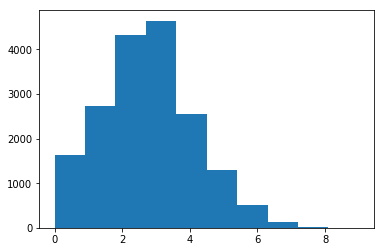

In [93]:
import matplotlib.pyplot as plt
plt.hist(np.sum(lasso_coefs != 0, axis=1))
plt.show()

In [95]:
max(np.sum(lasso_coefs != 0, axis=1))

9

In [55]:
#######################################
# Read in file with probe annotations from affymetrix (slightly preprocessed)
#######################################

# affy_map_file = "/cbscratch/franco/datasets/FHS/expression/HuEx-1_0-st-v2.na36.hg19.transcript.tab.csv"
# affy_map_file = "/cbscratch/franco/datasets/FHS/expression/ENSG_gene_affy_header.tsv"
affy_map_file = "/cbscratch/franco/datasets/FHS/expression/gene_assignment_short.affy"
dtype_dict = {'transcript_cluster_id':int,\
              'probeset_id':int,\
              'seqname':str,\
              'strand':str,\
              'start':str,\
              'stop':str,\
              'total_probes':str,\
              'gene_assignment':str}
affy_df = pd.read_csv(affy_map_file, sep="\t", comment="#", header=0, dtype=dtype_dict)

In [56]:
# np.sum(affy_df.mrna_assignment.str.contains("gene:")) # 19576
# np.sum(affy_df.mrna_assignment.str.contains("ENSG"))
# np.sum(affy_df.mrna_assignment.str.contains("protein_coding")) #9007
affy_df.head()

,transcript_cluster_id,probeset_id,seqname,strand,start,stop,total_probes,gene_assignment
0,2315100,2315100,chr1,+,11884,14409,20,NR_046018 // DDX11L1 // DEAD/H (Asp-Glu-Ala-As...
1,2315113,2315113,chr1,+,27563,27813,4,---
2,2315115,2315115,chr1,+,28425,29158,4,---
3,2315117,2315117,chr1,+,30623,30667,4,XR_936215 // LOC105376912 // uncharacterized L...
4,2315119,2315119,chr1,+,35690,35804,4,---


In [57]:
# ensembl_ids = affy_df.mrna_assignment.str.extract(r'(ENSG[0-9]*)')
# affy_df["ensemble_id"] = ensembl_ids
# affy_df.head()

In [58]:
FINAL_expr_annotations = affy_df[affy_df.transcript_cluster_id.isin(final_expr_FHS.index)]
FINAL_expr_annotations.to_csv("/cbscratch/franco/datasets/FHS/probe_annotations.affy", sep="\t", header=True, index=False)
print(FINAL_expr_annotations.shape)

(17865, 8)


In [59]:
import collections

GENEINFO_FIELDS = ['name', 'ensembl_id', 'chrom', 'start', 'end']
class GeneInfo(collections.namedtuple('_GeneInfo', GENEINFO_FIELDS)):
    __slots__ = ()
    
def affy_exon_chip(filepath, include_chrom = 0, include_chroms=['{:d}'.format(x + 1) for x in range(22)]):
    geneinfo = list()
    try:
        with open(filepath, 'r') as mfile:
            next(mfile) # skip header
            for line in mfile:
                linesplit = line.strip().split('\t')
                if linesplit[0][0] == '#' : continue 

                chrom = linesplit[2][3:]
                if include_chrom > 0:
                    include_chroms = ['{:d}'.format(include_chrom)]
                if chrom not in include_chroms: continue

                # TSS: gene start (0-based coordinates for BED)
                if linesplit[3] == '+':
                    start = np.int64(linesplit[4]) - 1
                    end   = np.int64(linesplit[5])
                elif linesplit[3] == '-':
                    start = np.int64(linesplit[4])  # last base of gene
                    end   = np.int64(linesplit[5]) - 1
                else:
                    raise ValueError('Strand not specified.')

                gene_name = linesplit[7].split("//")[0].rstrip()
                transcript_cluster_id = linesplit[0]
                this_gene = GeneInfo(name       = gene_name,
                                     ensembl_id = transcript_cluster_id,
                                     chrom      = int(chrom),
                                     start      = start,
                                     end        = end)

                geneinfo.append(this_gene)
    except IOError as err:
        raise IOError('{:s}: {:s}'.format(annotfile, err.strerror))

    return geneinfo

gene_info = affy_exon_chip("/cbscratch/franco/datasets/FHS/probe_annotations.affy")